# Projet PHYS-F-302 2019-2020  
##### Ducarme Eliott & Lahmaïd Ismaël

In [1]:
import numpy as np
from matplotlib import pyplot
import numba
from numba import jit

In [2]:
# Paramètres
nx = 101
xmin = 0
xmax = 1

l2_target = 1e-8

dx =(xmax-xmin)/(nx-1)
x = np.linspace(xmin,xmax,nx)

f_d = np.linspace(0,1,nx) #Ligne droite
f_0 = np.zeros(nx)        #Matrice nulle
f_0[-1] = 1 #Conditions de Dirichlet pour la dernière valeur de notre matrice

#erreur en norme L2
@jit
def L2_rel_error(p, pn):
    ''' Compute the relative L2 norm of the difference
    Parameters:
    ----------
    p : array of float
        array 1
    pn: array of float
        array 2
    Returns:
    -------
    Relative L2 norm of the difference
    '''
    return np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))

Soit l'équation différentielle linéaire à coefficients constants:

\begin{align}
\frac{d^4 f}{dx^4}-5 \frac{d^2 f}{dx^2}+ 4f = 0\hspace{5cm} (1)
\end{align}

où $f$ est une fonction de la variable $x\in [0\ 1]$. Par ailleurs, on a les conditions aux bords suivantes:

$$
f(0)=a, f'(0)=b, f(1)=c, f'(1)=d \hspace{3cm} (2)
$$

## Consignes:
    
- Pour les questions 4 et 5 prendre $nx=101$ pour discrétiser l'interval $x\in [0\ 1]$.
- Faites converger les méthodes itératives jusqu'à ce que la différence en norme L2 de deux itérations successives soit $<10^{-8}$.

### Question 1 (2 points)

Quelle est la solution générale de l'équation (1)?

<font color='blue'>
Supposons une solution de la forme $f(x)=e^{\lambda x}$ et injectons ce résultat dans l'équation différentielle. Nous obtenons alors:

\begin{align}
\frac{\partial^4}{\partial x^4} \left(e^{\lambda x}\right) - 5 \frac{\partial^2}{\partial x^2}\left(e^{\lambda x}\right) + 4\left(e^{\lambda x}\right) & = 0 \\
\lambda^4 e^{\lambda x} - 5\lambda^2 e^{\lambda x} + 4e^{\lambda x} & = 0 \\
\end{align}

Mettons en évidence notre $e^{\lambda x}$,

\begin{align}
\left(\lambda^4 - 5\lambda^2 + 4 \right) e^{\lambda x} & = 0
\end{align}

On rejette la solution triviale $e^{\lambda x}=0$, nous allons rechercher les solutions convergente. Ces solutions ne dépendent donc que de l'équation polynomiale $\lambda^4  - 5\lambda^2 + 4=0$. Remarquons que nous résolvons l'équation caractéristique de notre EDO:

\begin{align}
& \left(\lambda^4 - 5\lambda^2 + 4 \right) & = 0\\
\iff & \left(\lambda - 2\right)\left(\lambda - 1\right)\left(\lambda + 1\right)\left(\lambda + 2\right) & = 0
\end{align}

Lambda a donc pour solutions:
\begin{align}
\lambda & = \left\{ -2, -1, 1, 2\right\}
\end{align}.


La solution générale de notre EDO devient quant à elle

\begin{align}
f(x) & = C_1\cdot e^{-2x} + C_2\cdot e^{-x} + C_3\cdot e^{x} + C_4\cdot e^{2x}
\end{align}
<font>

### Question 2 (3 points)

Ecrire un code en python qui permet d'évaluer les constantes d'intégration de la solution générale en termes des conditions aux bords (2). Pour cette question vous pouvez vous servir de n'importe quelle routine fournie par numpy.

In [3]:
#on résout un système d'équations linéaires avec linalg
def boundaries_solve(bci,bcf,dbci,dbcf):
    a=np.array([[1,1,1,1],[np.exp(-2),np.exp(-1),np.exp(1),np.exp(2)],
                [-2,-1,1,2],[-2*np.exp(-2),-1*np.exp(-1),np.exp(1),2*np.exp(2)]])
    b=np.array([bci,bcf,dbci,dbcf])
    x=np.linalg.solve(a,b) #commande qui résout un système linéaire (cf sources)
    return x

### Question 3 (2 points)

Que vaut la solution de l'équation (1) pour $a=0, b=0, c=1, d=-1$. Représentez cette fonction sur un graphique.

In [4]:
#on résout pour nos conditions aux bords et on utilise la forme analytique de la question 1
C1, C2, C3, C4 = boundaries_solve(0,1,0,-1)
p0 = C1*np.exp(-2*x)+C2*np.exp(-x)+C3*np.exp(x)+C4*np.exp(2*x)
print(C1, C2, C3, C4)

3.352281437944153 -5.337391764428322 2.6030495415083523 -0.6179392150241839


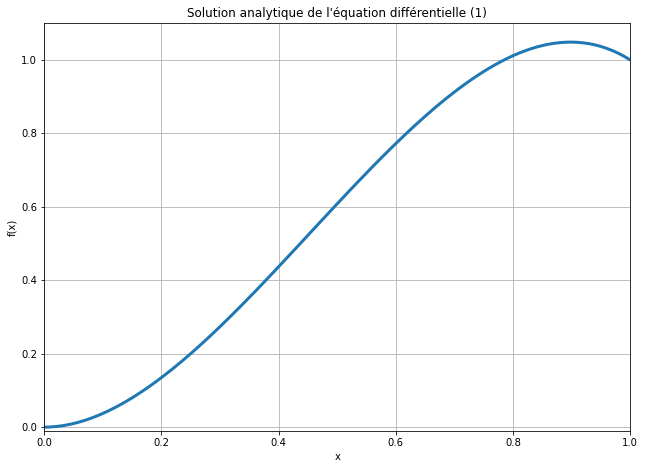

In [5]:
#--------------------------------- Graphe
pyplot.figure(figsize=(10.5,7.5))
pyplot.title('Solution analytique de l\'équation différentielle (1)' )
pyplot.xlabel('x')
pyplot.ylabel('f(x)')
pyplot.plot(x, p0,
            color='C0', linestyle='-',linewidth=3)
pyplot.xlim(0,1)
pyplot.ylim(-0.01,1.1)
pyplot.grid()

### Question 4 (6 points)

Résoudre l'équation (1) avec la méthode Gauss-Seidel vue dans le cours. Combien d'itérations sont nécessaires? Comparer votre solution avec la solution obtenue à la question 3 (graphiquement et en mesurant la norme L2 de la différence).

<font color='blue'>
    Pour utiliser la méthode de Gauss-Seidel, nous allons tout d'abord définir une discrétisation et les conditions aux bords adaptées à notre problème. Nous réutiliserons certains éléments pour la méthode du conjugate gradient.
<font>


#### 1. Discrétisation 
<font color='blue'>
    Nous commençons par discrétiser chaque terme de notre équation différentielle. Nous allons utiliser une central finite difference.

1.
\begin{align}
\frac{\partial^2 f}{\partial x^2} & = \frac{f_{i-1}-2f_i+f_{i+1}}{\Delta x^2}
\end{align}

2.
\begin{align}
 \frac{\partial^4 f}{\partial x^4} & = \frac{\partial^2}{\partial x^2}\left(\frac{\partial^2 f}{\partial x^2}\right)\\ 
                                   & = \frac{\left(\frac{\partial^2 f}{\partial x^2}\right)_{i-1} -2\left(\frac{\partial^2 f}{\partial x^2}\right)_i+\left(\frac{\partial^2 f}{\partial x^2}\right)_{i+1}}{\Delta x^2} \\
                                   & = \frac{(f_{i-1}-2f_i+f_{i+1})_{i-1}-2(f_{i-1}-2f_i+f_{i+1})_i+(f_{i-1}-2f_i+f_{i+1})_{i+1}}{\Delta x^4} \\
                                   & = \frac{f_{i-2}-2f_{i-1}+f_i-2f_{i-1}+4f_i-2f_{i+1}+f_i-2f_{i+1}+f_{i+2}}{\Delta x^4} \\
                                   & = \frac{f_{i-2}-4f_{i-1}+6f_i-4f_{i-1}+f_{i+2}}{\Delta x^4}
\end{align}
<font>

<font color='blue'>
Nous avons donc:
\begin{align}
\frac{\partial^4 f}{\partial x^4}-5\frac{\partial^2 f}{\partial x^2}+4f & = \frac{f_{i-2}-4f_{i-1}+6f_i-4f_{i-1}+f_{i+2}}{\Delta x^4} + 5\cdot \frac{f_{i-1}-2f_i+f_{i+1}}{\Delta x^2} +4f_i = 0
\end{align}
<font>

<font color='blue'>
Enfin, nous isolons le $f_i$ de notre discrétisation:

\begin{align}
f_i &= \frac{-f_{i-2}+(f_{i-1}+f_{i+1})\cdot (4+5\Delta x^2)-f_{i+2}}{6+10 \Delta x^2 + 4\Delta x^4}
\end{align}
<font>

#### 2. Conditions aux bords
<font color='blue'>
Afin de respecter  nos conditions aux bords de Von Neumann (ceux de Dirichlet étant suffisament explicites dans les énoncés précédentes) nous allons devoir faire un Backward Finite Difference à droite de notre domaine et un Forward Finite Difference à gauche de notre domaine afin de discrétiser nos dérivés. La discrétisation sera effectuée au 2e ordre d'approximation afin d'être compatible avec la norme $L_2$.

- FFD:
\begin{align}
\frac{-1.5 f_i + 2 f_{i+1} - 0.5f_{i+2}}{\Delta x}=0 &\Rightarrow 0 + 2 f_{i+1} - 0.5f_{i+2} = 0 \\
                                                   &\iff f_{i+1} = 0.25 f_{i+2}
\end{align}

- BFD:
\begin{align}
\frac{0.5f_{i-2} - 2 f_{i-1} +1.5 f_i }{\Delta x}=-1 &\Rightarrow 0.5f_{i-2} - 2 f_{i-1} + 1.5 = -\Delta x \\
                                                  &\iff f_{i-1} = 0.5\cdot \Delta x +0.75 +0.25 f_{i-2}
\end{align}
<font>

#### 3. Définition de l'algorithme de Gauss-Seidel
<font color='blue'>
Nous avons utilisé @jit de Numba afin de gagner du temps dans nos tests et peaufinements. Cela ne modifie bien évidemment en rien notre réponse finale.
<font>

In [6]:
@jit
def gauss_seidel(p0, nx, dx, maxiter=2000000, rtol=l2_target):
    """
    Solves the equation on a uniform grid
    with equal grid spacing in both directions
    using Gauss-Seidel relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 1D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 2000000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-8.
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 1D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.
    """
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        for i in range(2,nx-2):
            p[i]=(-p[i-2]+(p[i-1]+p[i+1])*(4+5*dx**2)-p[i+2])/(6+10*dx**2+4*dx**4)
        p[1], p[-2] = 0.25*p[2], 0.25*p[-3]+0.5*dx+0.75     #Von Neumann conditions
        diff = L2_rel_error(p, pn)
        conv.append(diff)
        ite += 1
    return p, ite, conv

<font color='blue'>
Afin de gagner un certain nombre d'itérations, nous avons utilisé, comme matrice de départ, une matrice définissant une droite passant de x=0 à x=1. Cela nous a permis de gagner pratiquement 1 million d'itérations par rapport à une matrice nulle.
<font>

In [7]:
p, ites, conv_gs =gauss_seidel(f_d, nx, dx, maxiter=2000000, rtol=l2_target)
print('The solution of the equation (1) with the Gauss-Seidel method is (for x in [0,1]): \n {}'.format(p))
print('\n Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

The solution of the equation (1) with the Gauss-Seidel method is (for x in [0,1]): 
 [0.00000000e+00 3.90554208e-04 1.56221683e-03 3.49260917e-03
 6.15973145e-03 9.54195157e-03 1.36179938e-02 1.83669274e-02
 2.37681560e-02 2.98014059e-02 3.64467155e-02 4.36844242e-02
 5.14951618e-02 5.98598375e-02 6.87596294e-02 7.81759737e-02
 8.80905544e-02 9.84852928e-02 1.09342337e-01 1.20644051e-01
 1.32373007e-01 1.44511971e-01 1.57043896e-01 1.69951912e-01
 1.83219314e-01 1.96829553e-01 2.10766228e-01 2.25013072e-01
 2.39553948e-01 2.54372834e-01 2.69453818e-01 2.84781083e-01
 3.00338905e-01 3.16111638e-01 3.32083705e-01 3.48239591e-01
 3.64563835e-01 3.81041015e-01 3.97655746e-01 4.14392667e-01
 4.31236431e-01 4.48171701e-01 4.65183135e-01 4.82255383e-01
 4.99373073e-01 5.16520807e-01 5.33683148e-01 5.50844615e-01
 5.67989673e-01 5.85102722e-01 6.02168092e-01 6.19170034e-01
 6.36092708e-01 6.52920181e-01 6.69636409e-01 6.86225239e-01
 7.02670392e-01 7.18955460e-01 7.35063895e-01 7.50978999e-01


L'erreur pour la droite comme initial guess donne une erreur en norme L2 = 0.005249


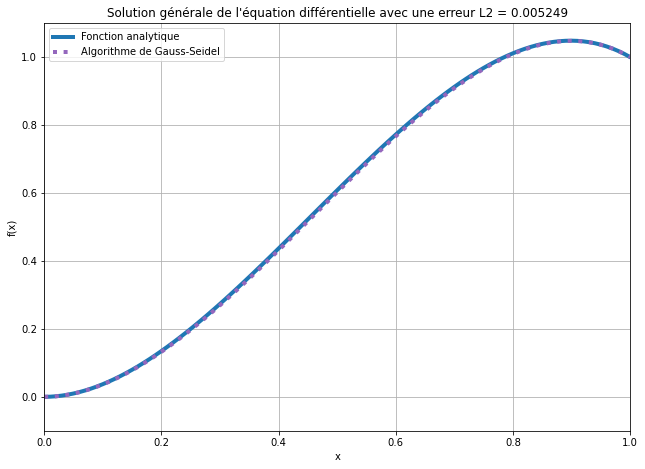

In [8]:
#--------------------------------- Différence en norme L2
err=L2_rel_error(p,p0)
print("L'erreur pour la droite comme initial guess donne une erreur en norme L2 = %f" % err)
#--------------------------------- Graphe
pyplot.figure(figsize=(10.5,7.5))
pyplot.title('Solution générale de l\'équation différentielle avec une erreur L2 = %f' % err)
pyplot.xlabel('x')
pyplot.ylabel('f(x)')
pyplot.plot(x, p0, label='Fonction analytique',
            color='C0', linestyle='-',linewidth=4)
pyplot.plot(x, p,label='Algorithme de Gauss-Seidel',
            color='C4', linestyle='dotted',linewidth=4)
pyplot.legend(loc='upper left')
pyplot.xlim(0,1)
pyplot.ylim(-0.1,1.1)
pyplot.grid()

### Question 5 (7 points)

Résoudre l'équation (1) avec la méthode du gradient conjugué vue dans le cours. Combien d'itérations sont nécessaires? Comparer votre solution avec la solution obtenue à la question 3 (graphiquement et en mesurant la norme L2 de la différence).

In [9]:
def conjugate_gradient(p, dx, l2_target):
    
    nx= p.shape
    r  = np.zeros(nx) # On initie le résidu
    Ad  = np.zeros(nx) #  et la matrice 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    #le résidu initial est calculée à partir de p.
    #Il faut initier les conditions de von Neumann pour éviter une erreur
    
    p[1] = 1/4*p[2]
    p[-2] = 1/2*(dx + 1.5 + 1/2*p[-3])
    
    
    r[2:-2] = (p[:-4] -4*p[1:-3] + 6*p[2:-2] - 4*p[3:-1] + p[4:])/dx**4 \
                        - 5*(p[1:-3] - 2*p[2:-2] + p[3:-1])/dx**2 + 4*p[2:-2]
    
    d = r.copy()    #pour la première direction, on la choisit comme exactement le résidu
    
    #condition de von Neumann pour avoir une direction correcte
    
    d[1] = 1/4*d[2]
    d[-2] = 1/2*(dx + 1.5 + 1/2*d[-3])
    
    #calcul de alpha pour établir le prochain résidu
    rho = np.sum(r*r)
    
    #produit de A et du vecteur de direction
    Ad[2:-2] = (- d[:-4] + 4*d[1:-3] - 6*d[2:-2] + 4*d[3:-1] - d[4:])/dx**4 \
                            + 5*(d[1:-3] - 2*d[2:-2] + d[3:-1])/dx**2 - 4*d[2:-2]
    
    sigma = np.sum(d*Ad)
    
    # La boucle d'itération
    while l2_norm > l2_target:
        
        #on stocke la précédente itération
        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma
        p = pk + alpha*dk
        r = rk - alpha*Ad 
        
        #on choisit la nouvelle direction 
        rhop1 = np.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        d = r + beta*dk
        
        #on calcule les conditions de von Neumann
        d[1] = 1/4*d[2]
        d[-2] = 1/2*(dx + 1.5 + 1/2*d[-3])
        
        Ad[2:-2] = (- d[:-4] + 4*d[1:-3] - 6*d[2:-2] + 4*d[3:-1] - d[4:])/dx**4 \
                                + 5*(d[1:-3] - 2*d[2:-2] + d[3:-1])/dx**2 - 4*d[2:-2]
        
        sigma = np.sum(d*Ad)
        
        #on compare le nouveau résultat et le précédent
        l2_norm = L2_rel_error(pk,p)
        iterations += 1
        l2_conv.append(l2_norm)
        
    print('Iterations nécessaire au calcul: %i' % iterations) #La première solution sortante est pour une matrice initiale nulle, la seconde pour une droite
    return p, l2_conv

CG_0, l2_conv = conjugate_gradient(f_0, dx, l2_target)
CG_D, l2_conv = conjugate_gradient(f_d, dx, l2_target)

Iterations nécessaire au calcul: 2098
Iterations nécessaire au calcul: 1723


L'erreur pour la droite comme initial guess donne une erreur en norme L2 = 0.000221


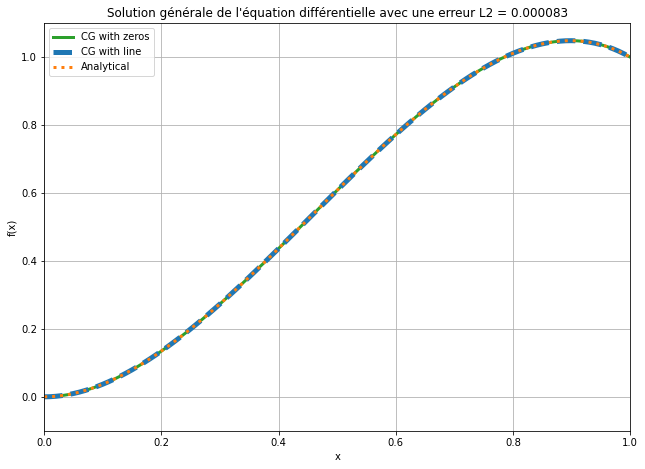

In [10]:
#--------------------------------- Différence en norme L2
#on calcule l'erreur donnée par la méthode CG
err_0 = L2_rel_error(CG_0,p0)
err_D = L2_rel_error(CG_D,p0)
print("L'erreur pour la droite comme initial guess donne une erreur en norme L2 = %f" % err_D) #La seconde erreur est affichée dans le titre du graphique
#--------------------------------- Graphe
pyplot.figure(figsize=(10.5,7.5))
pyplot.title('Solution générale de l\'équation différentielle avec une erreur L2 = %f' % err_0 )
pyplot.xlabel('x')
pyplot.ylabel('f(x)')
pyplot.plot(x, CG_0, color='C2', linestyle='-', linewidth=3, label='CG with zeros')
pyplot.plot(x, CG_D, color='C0', linestyle='dashed', linewidth=5, label='CG with line')
pyplot.plot(x, p0, color='C1', linestyle='dotted', linewidth = 3, label='Analytical')
pyplot.legend()
pyplot.xlim(0,1)
pyplot.ylim(-0.1,1.1)
pyplot.grid()

## Conclusions:
<font color='blue'>
La méthode de Gauss-Seidel est une méthode longue nécessitant de nombreuses itérations. Elle n'est pas si précise (de l'ordre du $10^{-3}$) et le processus est assez long à (r)exécuter (sans l'aide de numba).

A contrario, la méthode du gradient conjugué, même si plus fastidieuse à implémenter, est nettement plus rapide et ne requiert pas d'utiliser d'import supplémentaire pour être efficace. 

On remarquera également que le choix d'une droite comme guess initial permet une amélioration du nombre d'itérations. Par contre, le CG est moins précis (mais toujours plus que Gauss-Seidel) dans ce cas là. En fonction de ce qui est recherché le choix de la droite ou d'un array de zéro peuvent être considérés.
<font>

## Source:
- https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.solve.html
- https://en.wikipedia.org/wiki/Finite_difference_coefficient